# Robot Localization in a maze

Imagine you have a patrolling robot which moves in an indoor environment (in a “maze”). You have a map of the maze, but neither the maze, nor the robot is equipped with sensors of
the absolute position of the robot. You have to estimate its position, i.e. estimate its hidden state, from a sequence of observations.

<sup><sub>Homework modified from BE3M33UI - Artificial Intelligence course</sub></sup>
## Robot Movements
The robot can move one step north, east, south, or west. Each time slice, the robot issues a move
command, but the actual movement direction is chosen randomly. The probability distribution
over these directions is known and in many positions,
only some of these directions are admissible (because of walls). In that case, the robot chooses only among the
admissible directions. (This information shall be sufficient to compute the transition model
$P(X_t|X_{t−1})$ where $X_t$
is the position of the robot at time $t$.)

## Robot Observations
The robot is equipped with four “near-far sensors” which provide a very rough information
about the distance to the nearest walls in specified directions. The output of each of the four
sensors is either 'n' or 'f', meaning that the wall is near or far. Moreover, the sensor information is noisy in the sense that the probability of returning symbol 'n' grows with decreasing
distance to wall and vice versa for symbol 'f'. The four sensors are independent.
There are 24 = 16 possible observations: from (n,n,n,n) to (f,f,f,f). (This shall be sufficient to
compute the emission model $P(E_t
|Xt)$.)

## Code
You are provided with the following classes which implements the “robot in a maze” environment as a HMM



In [1]:
# Code modified from BE3M33UI - Artificial Intelligence course

import random
from collections import Counter
from itertools import product
import itertools
import matplotlib.pyplot as plt
import bisect

NORTH = (-1, 0)
EAST = (0, 1)
SOUTH = (1, 0)
WEST = (0, -1)
ALL_DIRS = (NORTH, EAST, SOUTH, WEST)

DEFAULT_MOVE_PROBS = {
    NORTH: 0.25,
    EAST: 0.25,
    SOUTH: 0.25,
    WEST: 0.25
}

def weighted_random_choice(pdist):
    """Choose an element from distribution given as dict of values and their probs."""
    weighted_choices = [(k,v) for k,v in pdist.items()]
    choices, weights = zip(*weighted_choices)
    cumdist = list(itertools.accumulate(weights))
    x = random.random() * cumdist[-1]
    return choices[bisect.bisect(cumdist, x)]

def normalized(P, factor=None, return_normalization_factor=False):
    """Return a normalized copy of the distribution given as a Counter"""
    if not factor:
        s = sum(P.values())
        factor = 1 / s
    norm = Counter({k: factor*v for k, v in P.items()})
    if return_normalization_factor:
        return norm, factor
    else:
        return norm

def add(s, dir):
    """Add direction to a state"""
    return tuple(a+b for a, b in zip(s, dir))


def direction(s1, s2):
    """Return a direction vector from s1 to s2"""
    return tuple(b-a for a, b in zip(s1, s2))


def manhattan(s1, s2):
    return sum(abs(a) for a in direction(s1, s2))


class Maze:
    """Representation of a maze"""

    WALL_CHAR = '#'
    FREE_CHAR = ' '

    def __init__(self, map):
        self.load_map(map)
        self._free_positions = []
        self._grid = []
        

    def load_map(self, map_fname):
        """Load map from a text file"""
        self.map = []
        with open(map_fname, 'rt', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line: continue
                self.map.append(line)
        self.map = tuple(self.map)
        self.height = len(self.map)
        self.width = len(self.map[0])
        self.min_pos = (1, 1)
        self.max_pos = (len(self.map)-2, len(self.map[0])-2)

    def __str__(self):
        """Return a string representation of the maze"""
        return '\n'.join(self.map)

    def is_free(self, pos):
        """Check whether a position is free
        
        :param pos: position as (row, column)
        :return: True or False
        """
        return self.map[pos[0]][pos[1]] == self.FREE_CHAR

    def is_wall(self, pos):
        """Check whether a position contains a wall

        :param pos: position as (row, column)
        :return: True or False
        """
        return self.map[pos[0]][pos[1]] == self.WALL_CHAR

    def get_free_positions(self, search=False):
        """Return a list of all free positions in the maze
        
        It returns a cached list, if the free positions were already precomputed.
        """
        # If free positions already found and shouldn't find them anew
        if self._free_positions and not search:
            return self._free_positions
        fp = []
        for r in range(1, self.height-1):
            for c in range(1, self.width-1):
                pos = (r, c)
                if self.is_free(pos):
                    fp.append(pos)
        self._free_positions = fp
        return fp

    def get_wall_positions(self):
        """Return a list of all maze positions containing walls"""
        wp = []
        for r in range(0, self.height):
            for c in range(0, self.width):
                pos = (r, c)
                if self.is_wall(pos):
                    wp.append(pos)
        return wp

    def get_dist_to_wall(self, pos, dir):
        """Return the distance to the nearest wall.
        
        Distance is the number of steps one can make from
        the given position to the closest wall in the given direction.
        
        :param pos: (row, column) tuple 
        :param dir: One of the following:
                    (-1, 0) ... north
                    (0, 1) ... east
                    (1, 0) ... south
                    (0, -1) ... west
        :return: int, distance to wall
        """
        if pos not in self.get_free_positions():
            raise ValueError('The specified robot position is not allowable. Did you use (row, column)?')
        d = 0
        while True:
            pos = add(pos, dir)
            if not self.is_free(pos):
                return d
            d += 1

    def get_grid(self, search=False):
        """Displays the maze
        """
        # If free positions already found and shouldn't find them anew
        #if self._grid and not search:
        #    return self._grid
        grid = []
        for r in range(self.height):
            grow = []
            for c in range(self.width):
                pos = (r, c)
                if self.is_free(pos):
                    grow.append(1)
                else:
                    grow.append(0)
            grid.append(grow)
        self._grid = grid
        return grid

    def display(self, prob=None, state=None):
    
      grid = self.get_grid()  
      plt.imshow(self.get_grid(), cmap='gray', interpolation='nearest')

      if prob:
        for pos in self.get_free_positions():
          grid[pos[0]][pos[1]] = grid[pos[0]][pos[1]] * prob[pos]
        plt.imshow(grid, cmap='Purples', alpha=.7, interpolation='nearest')

      if state:
        plt.text(state[1],state[0], '*')

      plt.show()

class NearFarSensor:
    """Crude sensor measuring direction"""

    VALUES = ['n', 'f']
    DIST_OF_SURE_FAR = 4  # For this distance and larger, the sensor will surely return 'f'

    def __init__(self, robot, direction):
        """Initialize sensor
        
        :param robot: Robot, to which this sensor belongs
        :param direction: direction, 2-tuple, of the sensor
        """
        self.robot = robot
        self.dir = direction

    def get_value_probabilities(self):
        """Return the probabilities of individual observations depending on robot position"""
        dist = self.robot.get_dist_to_wall(self.dir)
        p = {}
        p['n'] = max([1 - dist/self.DIST_OF_SURE_FAR, 0])
        p['f'] = 1 - p['n']
        return p

    def read(self):
        """Return a single sensor reading depending on robot position"""
        p = self.get_value_probabilities()
        return weighted_random_choice(p)


In [2]:
class Robot():
    """Robot in a maze as HMM"""

    def __init__(self, sensor_directions=None, move_probs=None):
        """Initialize robot with sensors and transition model
        
        :param sensor_directions: list of directions of individual sensors
        :param move_probs: distribution over move directions 
        """
        self.maze = None
        self.position = None
        if not sensor_directions:
            sensor_directions = ALL_DIRS
        self.sensors = []
        for dir in sensor_directions:
            self.sensors.append(NearFarSensor(robot=self, direction=dir))
        self.move_probs = move_probs if move_probs else DEFAULT_MOVE_PROBS

    def observe(self, state=None):
        """Perform single observation of all sensors
        
        :param state: robot state (position) for which the observation
                      shall be made. If no state is given, the current 
                      robot position is used.
        :return: tuple of individual sensor readings
        """
        if not state:
            return tuple(s.read() for s in self.sensors)
        saved_pos = self.position
        self.position = state
        obs = self.observe()
        self.position = saved_pos
        return obs

    def _next_move_dir(self):
        """Return the direction of next move"""
        return weighted_random_choice(self.move_probs)

    def get_dist_to_wall(self, dir, pos=None):
        """Return the distance to wall"""
        if not pos:
            pos = self.position
        return self.maze.get_dist_to_wall(pos, dir)

    def get_states(self):
        """Return the list of possible states"""
        return self.maze.get_free_positions()

    def get_targets(self, state):
        """Return the list of all states reachable in one step from the given state"""
        tgts = [state]
        for dir in ALL_DIRS:
            next_state = add(state, dir)
            if not self.maze.is_free(next_state): continue
            tgts.append(next_state)
        return tgts

    def get_observations(self):
        """Return the list of all possible observations"""
        sensor_domains = [s.VALUES for s in self.sensors]
        return list(product(*sensor_domains))

    def get_next_state_distr(self, cur_state):
        """Return the distribution over possible next states
        
        Takes the walls around current state into account.
        """
        p = Counter()
        for dir in ALL_DIRS:
            next_state = add(cur_state, dir)
            if not self.maze.is_free(next_state):
                pass
            else:
                p[next_state] = self.move_probs[dir]
        return normalized(p)

    def pt(self, cur_state, next_state):
        """Return a single transition probability"""
        p = self.get_next_state_distr(cur_state)
        return p[next_state]

    def pe(self, pos, obs):
        """Return the probability of observing obs in state pos"""
        # Store current robot position and set a new one
        stored_pos = self.position
        self.position = pos
        # Compute the probability of observation
        p = 1
        for sensor, value in zip(self.sensors, obs):
            pd = sensor.get_value_probabilities()
            p *= pd[value]
        # Restore robot position
        self.position = stored_pos
        return p

    def set_random_position(self):
        """Set the robot to a random admissible state"""
        self.position = random.choice(self.maze.get_free_positions())

    def step(self, state=None):
        """Generate a next state for the current state"""
        if not state:
            state = self.position
        next_dist = {next_state: self.pt(state, next_state)
                     for next_state in self.get_targets(state)}
        # Sample from the distribution
        next_pos =  weighted_random_choice(next_dist)
        self.position = next_pos
        return next_pos

    def simulate(self, init_state=None, n_steps=5):
        """Perform several simulation steps starting from the given initial state

        :return: 2-tuple, sequence of states, and sequence of observations
        """
        if not init_state:
            init_state = self.position
        return self._simulate(init_state, n_steps)

    def _simulate(self, init_state, n_steps):
        """Perform several simulation steps starting from the given initial state

        :return: 2-tuple, sequence of states, and sequence of observations
        """
        last_state = init_state
        states, observations = [], []
        for i in range(n_steps):
            state = self.step(last_state)
            observation = self.observe(state)
            states.append(state)
            observations.append(observation)
            last_state = state
        return states, observations



## Class Maze
Class Maze represents the maze a robot will be situated in. The representation of a maze is just a text file using '#' as the character for a wall, so that you can easilly
create your own mazes. Some predefined mazes are provided with this file. Upload them to google colab. A maze can be loaded from
a text file and printed/displayed.

Among other things, you can also ask a maze object, whether a certain position is free or
contains a wall, and what is the distance from certain position to the closest wall in certain
direction (NORTH, EAST, SOUTH, and WEST are just symbolic names for direction vectors defined in the code above.


##########
#   #    #
# # ###  #
# #    # #
##  ## # #
#  # # # #
## # #   #
#    # # #
# #  # # #
##########


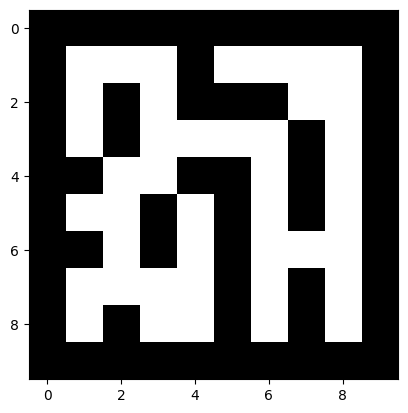

False
True
0


In [3]:
m = Maze('mazes/mazes/rect_8x8_maze.map')
print(m)
m.display()

print(m.is_free((0,0)))
print(m.is_wall((0,0)))
print(m.get_dist_to_wall((1,1), NORTH))


## Class Robot
Class Robot implements our HMM interface. It represents a robot that knows
in what maze it is situated, knows its own position and provides its transition and emission
models.

The following code creates a robot, i.e. robot with near-far sensors in all 4 directions, and with
0.25 probability of moving to each of the 4 directions. 
```
robot = Robot()
robot.maze = Maze('./rect_6x10_obstacles.map')
robot.position = (1, 1) # start position
```

The robot takes a step and gets the observations from the sensor using 
```
state = robot.step()
observation = robot.observe(state)
```

The transition probability $P(X_t|X_{t-1})$ is obtained using
```
x0 = (1,1)
x1 = (1,2)
robot.pt(x0, x1) 
```
The sensor model $P(E_t|X_t)$ is obtained using
```
robot.pe(state, observation)
```

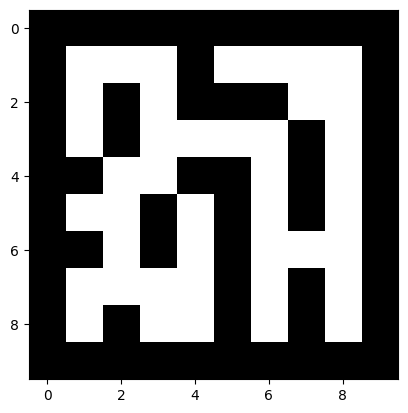

In [4]:
robot = Robot()
robot.maze = Maze('mazes/mazes/rect_8x8_maze.map')
robot.position = (1, 1) # start position
robot.maze.display()

## Task
The task is to implement the filtering algorithm, i.e to compute the $P(X_t|E_{1:t})$

You need to implement the function `forward` which implements the filtering algorithm and returns the probability for each free location as a python dictionary.
```
total_free_positions = len(robot.maze.get_free_positions())
```
The $P(X_0)$ is a uniform distribution computed as follows:
```
total_free_positions = len(robot.maze.get_free_positions())
filt_prob = {x:1/total_free_positions for x in robot.maze.get_free_positions()}
```

In [5]:
# input robot: robot in the maze instance
# filt_prob: previous estimate of the location (P(X_t|e_1:t))
# observation: current observation vector       
def forward(robot, filt_prob, observation):
    
    # Get all free positions in the maze
    allStates = robot.get_states()
    
    # Calculate the predicted probability of being in each position
    pred_prob = {}
    for pos in allStates:
        # Calculate the probability of transitioning from each previous position to the current position
        prob_sum = 0
        for prev_pos in allStates:
            prob_sum += robot.pt(prev_pos, pos) * filt_prob[prev_pos]
        # Multiply by the probability of the current observation given the current position
        pred_prob[pos] = prob_sum * robot.pe(pos, observation)
    
    # Normalize the probabilities
    s = sum(pred_prob.values())
    filt_prob = {key: value / s for key, value in pred_prob.items()}

    return filt_prob

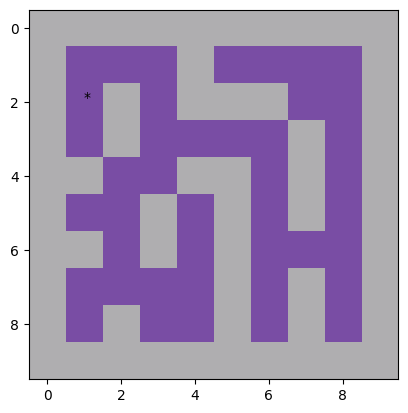

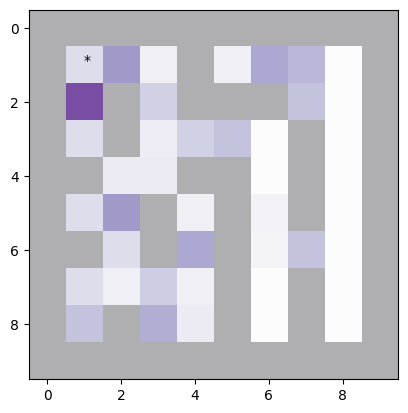

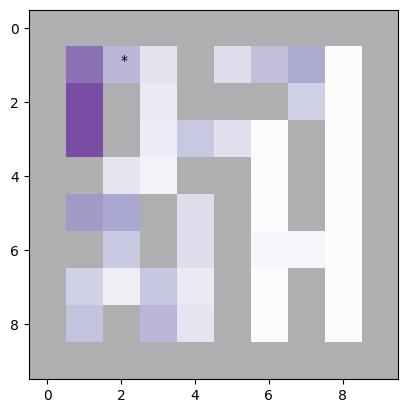

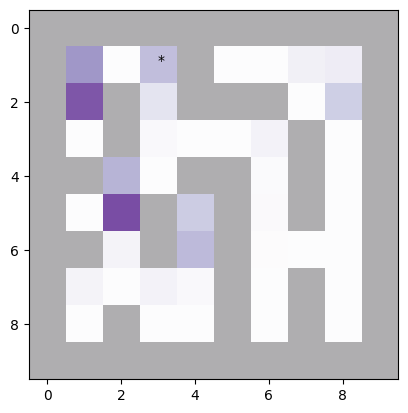

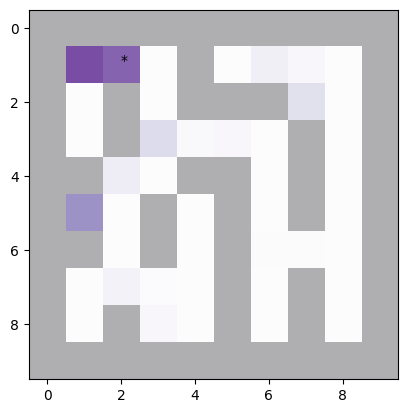

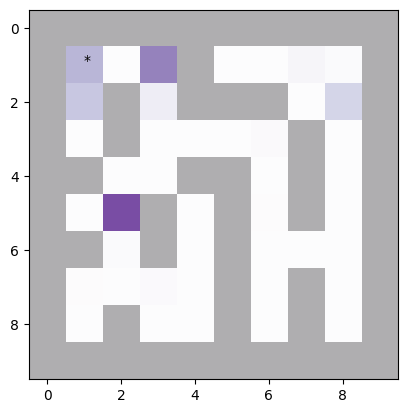

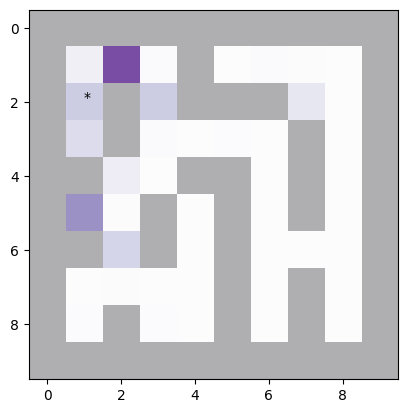

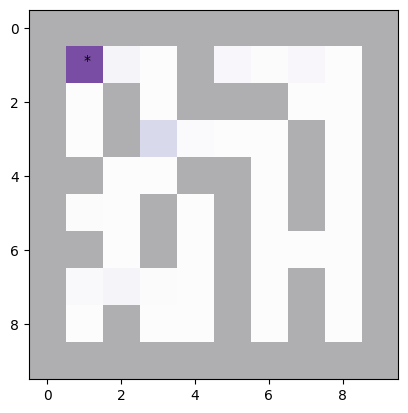

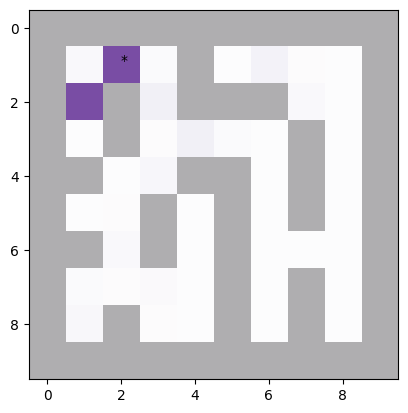

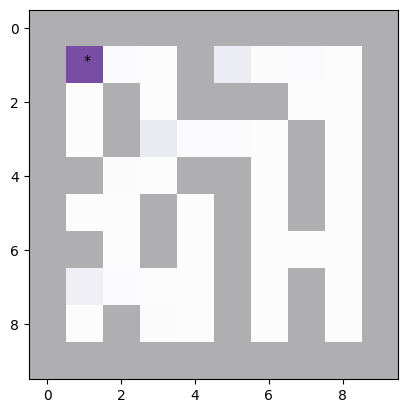

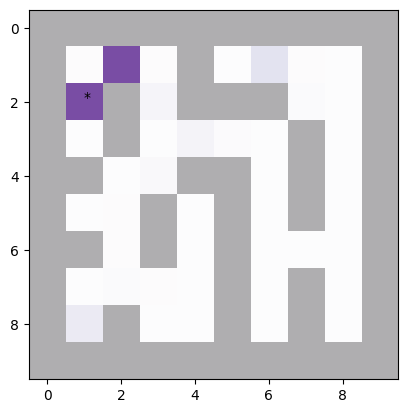

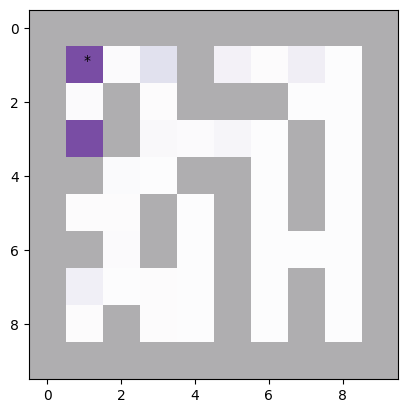

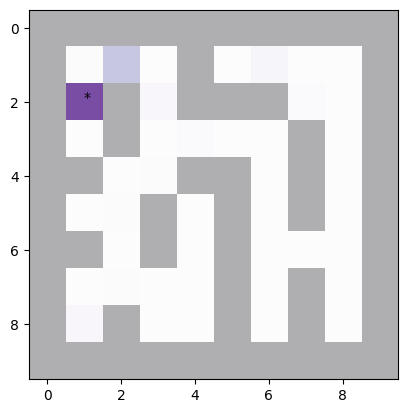

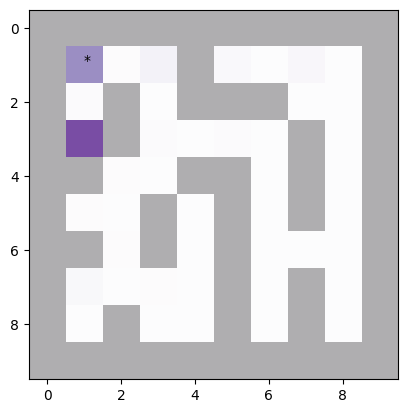

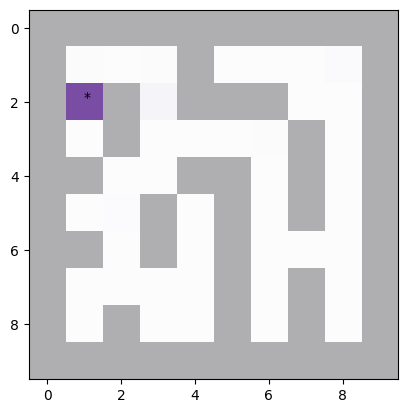

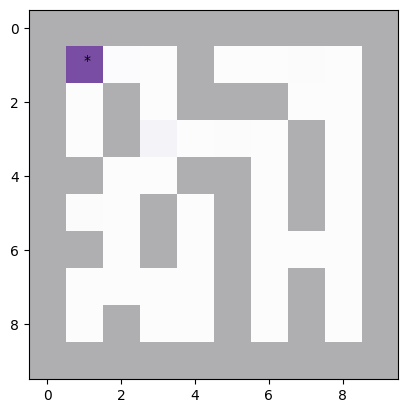

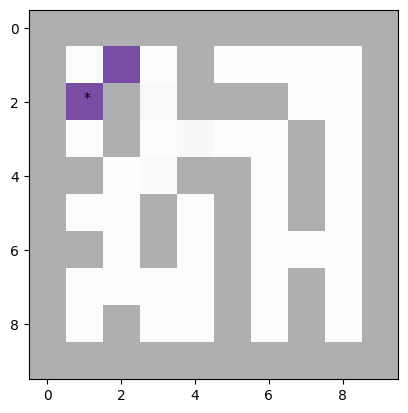

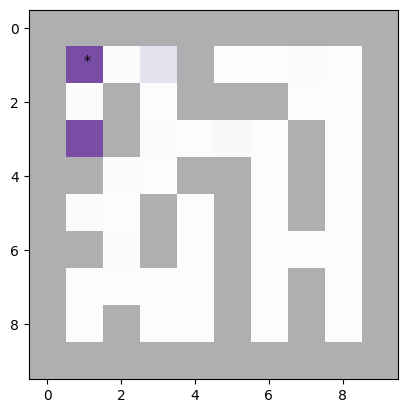

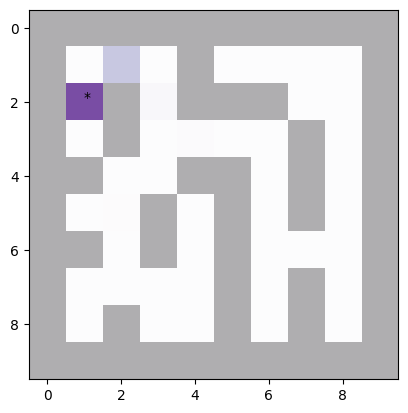

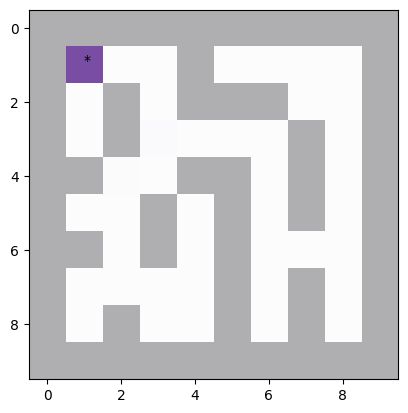

In [6]:
# uniform distribution for all free positions (prior belief)
total_free_positions = len(robot.maze.get_free_positions())
filt_prob = {x:1/total_free_positions for x in robot.maze.get_free_positions()}

state = (1, 1)

#Simulate 10 steps
for i in range(20):
  # display
  
  observation = robot.observe(state) 
  state = robot.step()
  
  robot.maze.display(filt_prob, state)
  
  # The function forward implements the filtering algorihtm and returns the probability for each free location as a dictionary
  filt_prob = forward(robot, filt_prob, observation)
  
  
  
  